<a href="https://colab.research.google.com/github/aherrera179/Trabajo-IM/blob/main/Algoritmo_opcionA_v0_1_Clusterizacion_Minimizacion_deltaUNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias

---



In [1]:
!pip install odfpy --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.0/717.0 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#!pip install --quiet --upgrade gspread gspread_dataframe

from google.colab import auth
from google.colab import drive
import matplotlib.pyplot as plt
import re, os
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import timedelta
import pandas as pd, numpy as np, re, os
from datetime import timedelta
import gspread
import google.auth
import matplotlib.patches as mpatches
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from math import ceil

In [ ]:
# 2) Obtener las credenciales activas y autorizar gspread

auth.authenticate_user()
creds, _ = google.auth.default()   # <-- aquí están las credenciales válidas
gc = gspread.authorize(creds)

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Coordenadas de Contenedores, se saco de la descarga de GOL - Levantes desde - hasta, ademas se hace un conversion a coordenadas UTM y WGS

In [ ]:
# === 1) Cargar CSV y normalizar columnas ===
path = Path("/content/exportacion_consulta-levantes_desde-hasta(1).csv")  # ajustá si va en otra carpeta
df = pd.read_csv(path, dtype=str, encoding="utf-8", on_bad_lines="skip")
df.columns = (df.columns
              .str.strip().str.lower()
              .str.replace(r"\s+", "_", regex=True))

# === 2) Detectar columnas gid y the_geom (flexible) ===
def pick_gid_col(cols):
    if "gid" in cols: return "gid"
    for c in ["id_contenedor","idcont","id","gid_cont","gidcont","gid_"]:
        if c in cols: return c
    for c in cols:
        if "gid" in c: return c
    return None

def pick_geom_col(cols):
    if "the_geom" in cols: return "the_geom"
    for c in cols:
        if "geom" in c: return c
    return None

gid_col  = pick_gid_col(df.columns)
geom_col = pick_geom_col(df.columns)

# 🟢 detectar circuito (si existe)
circuito_col = None
for c in df.columns:
    if "circuito" in c.lower():
        circuito_col = c
        break

if not gid_col or not geom_col:
    raise RuntimeError(f"No encontré columnas: gid=({gid_col}) geom=({geom_col}). Revisá nombres de columnas.")

# === 3) Parser de POINT ===
num_pat = r"[-+]?(?:\d+(?:\.\d*)?|\.\d+)"
rx_all_nums = re.compile(num_pat)

def parse_point(val: str):
    if not isinstance(val, str):
        return (np.nan, np.nan)
    s = val.strip()
    if ";" in s and s.upper().startswith("SRID="):
        s = s.split(";", 1)[1].strip()
    s = re.sub(r"^point(\s+z|\s+m|\s+zm)?", "", s, flags=re.IGNORECASE).strip()
    m = re.search(r"\((.*)\)", s)
    inside = m.group(1) if m else s
    inside = inside.replace(",", " ")
    nums = rx_all_nums.findall(inside)
    if len(nums) < 2:
        return (np.nan, np.nan)
    try:
        return float(nums[0]), float(nums[1])
    except Exception:
        return (np.nan, np.nan)

# === 4) Limpiar y extraer coordenadas ===
cols_to_keep = [gid_col, geom_col] + ([circuito_col] if circuito_col else [])
wrk = df[cols_to_keep].copy()
wrk.rename(columns={gid_col: "gid", geom_col: "the_geom"}, inplace=True)
if circuito_col:
    wrk.rename(columns={circuito_col: "circuito"}, inplace=True)  # 🟢 renombrar circuito

wrk["gid"] = wrk["gid"].astype(str).str.strip()
wrk = wrk.dropna(subset=["gid", "the_geom"])

coords = wrk["the_geom"].apply(parse_point)
wrk["x"] = coords.apply(lambda t: t[0])
wrk["y"] = coords.apply(lambda t: t[1])
wrk = wrk.dropna(subset=["x","y"])

# === 5) Un solo registro por gid (manteniendo circuito) ===
dedup_cols = ["gid","x","y"] + (["circuito"] if "circuito" in wrk.columns else [])
df_geom = (wrk[dedup_cols]
           .drop_duplicates(subset=["gid"], keep="first")
           .reset_index(drop=True))

print(f"Total filas origen: {len(df)}")
print(f"Con geom válido:    {len(wrk)}")
print(f"GIDs únicos:        {df_geom['gid'].nunique()}")

print("\nMuestra:")
print(df_geom.head(10))

# === 6) Guardar en UTM ===
out_utm = "/content/gid_coords_utm21s.csv"
df_geom.rename(columns={"x":"x_utm", "y":"y_utm"}, inplace=True)
df_geom.to_csv(out_utm, index=False, encoding="utf-8-sig")
print(f"\nOK (UTM 21S) -> {out_utm}")

# === 7) Reproyección a WGS84 ===
try:
    from pyproj import Transformer
    transformer = Transformer.from_crs("EPSG:32721", "EPSG:4326", always_xy=True)
    lon, lat = transformer.transform(df_geom["x_utm"].to_numpy(),
                                     df_geom["y_utm"].to_numpy())
    df_ll = df_geom.copy()
    df_ll["lon"] = lon
    df_ll["lat"] = lat

    out_wgs = "/content/gid_coords_wgs84.csv"
    df_ll.to_csv(out_wgs, index=False, encoding="utf-8-sig")
    print(f"OK (WGS84) -> {out_wgs}")

except Exception as e:
    print("No pude reproyectar a WGS84. Comentario:", e)

Total filas origen: 189273
Con geom válido:    189273
GIDs únicos:        11976

Muestra:
      gid              x             y circuito
0  177687  574673.683640  6.137302e+06     B_04
1  177708  574658.326627  6.137339e+06     B_04
2  177709  574638.205780  6.137392e+06     B_04
3  177710  574712.169278  6.137436e+06     B_04
4  177711  574752.705166  6.137321e+06     B_04
5  177712  574753.550050  6.137319e+06     B_04
6  177715  574833.029789  6.137371e+06     B_04
7  179373  574714.066720  6.137378e+06     B_04
8  179374  574672.051937  6.137359e+06     B_04
9  177779  574933.907986  6.137440e+06     B_04

OK (UTM 21S) -> /content/gid_coords_utm21s.csv
OK (WGS84) -> /content/gid_coords_wgs84.csv


Carga de Snapshot GOL

# Ultimas versiones para probar - 08/12/25

Días reales: [datetime.date(2025, 11, 3), datetime.date(2025, 11, 4), datetime.date(2025, 11, 5), datetime.date(2025, 11, 6), datetime.date(2025, 11, 7), datetime.date(2025, 11, 8)]

Día: 2025-11-03
Programados reales: 794
Contenedores bloqueados = 0
CAP_EFECTIVO: 733
K sugerido: 6


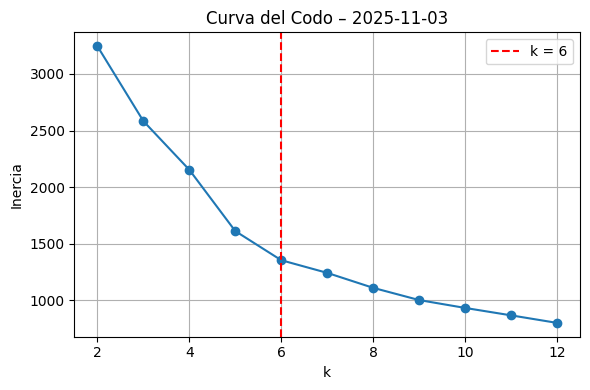


=== Resumen por clúster ===
            n  una_med  una_sum
cluster                        
0         653    249.0   175912
1        1492    106.0   152654
2        1407     89.0   145979
3        1157    120.0   143887
4        1344     89.0    99411
5          35    991.0    39102


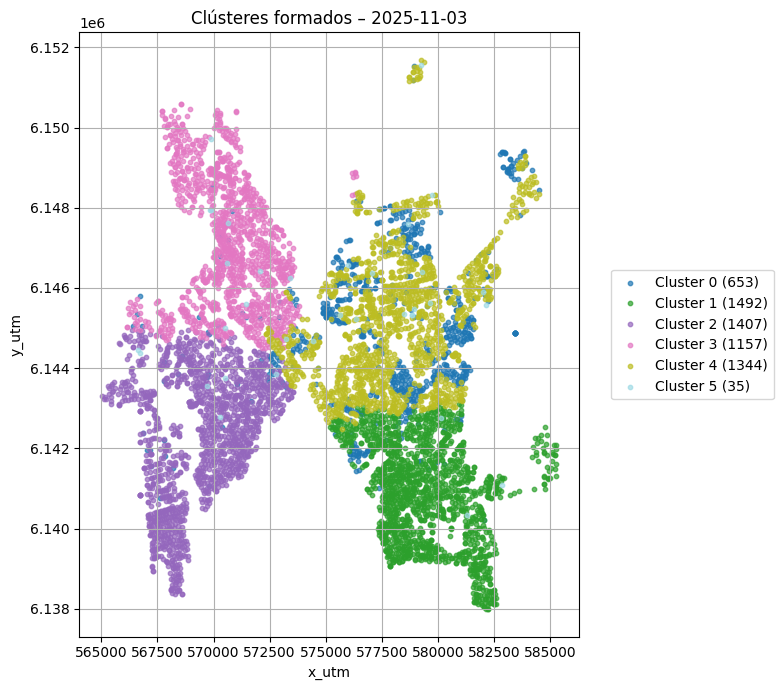


Cuotas suaves por municipio (día 2025-11-03 ):
  MUN_UNICO: 733.0

Total asignados algoritmo = 733 (objetivo CAP_TOTAL = 733)
Eficiencia real:  0.400
Eficiencia algo: 0.933


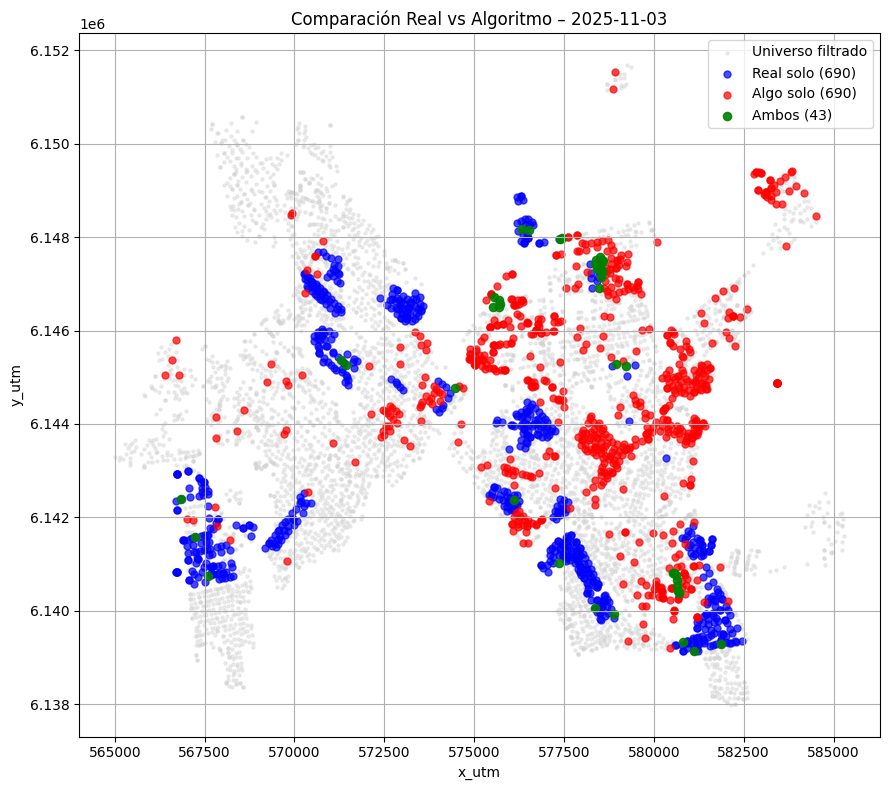


Día: 2025-11-04
Programados reales: 629
Contenedores bloqueados = 6557
CAP_EFECTIVO: 575
K sugerido: 5


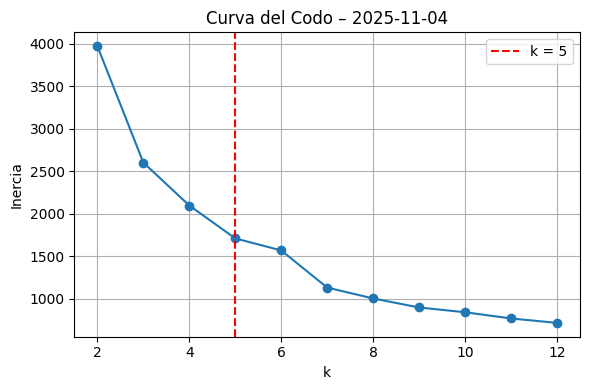


=== Resumen por clúster ===
            n  una_med  una_sum
cluster                        
0        1538    141.0   201865
2        1507    141.0   180902
1        1761     55.0   164425
4        1198    129.0   129666
3          56    857.5    63727


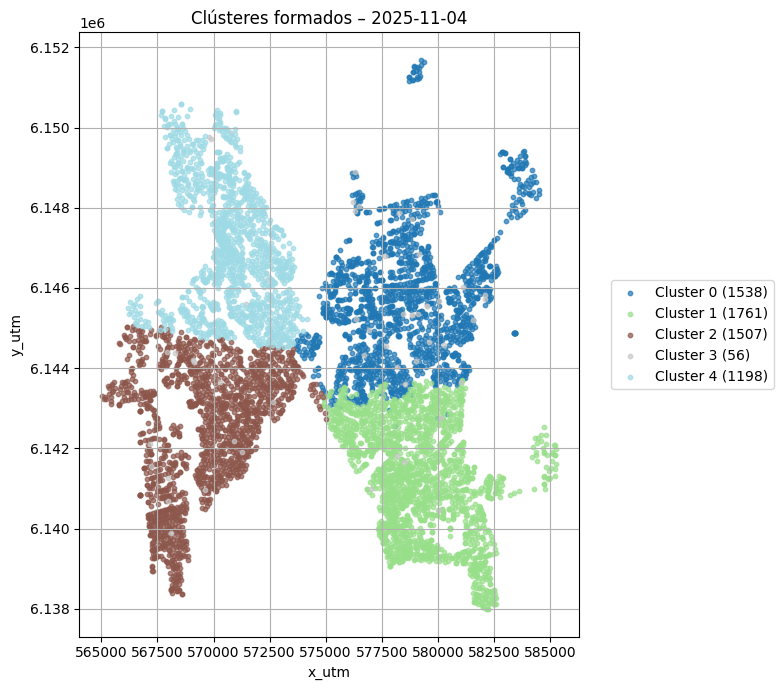


Cuotas suaves por municipio (día 2025-11-04 ):
  MUN_UNICO: 575.0

Total asignados algoritmo = 575 (objetivo CAP_TOTAL = 575)
Eficiencia real:  0.757
Eficiencia algo: 0.720


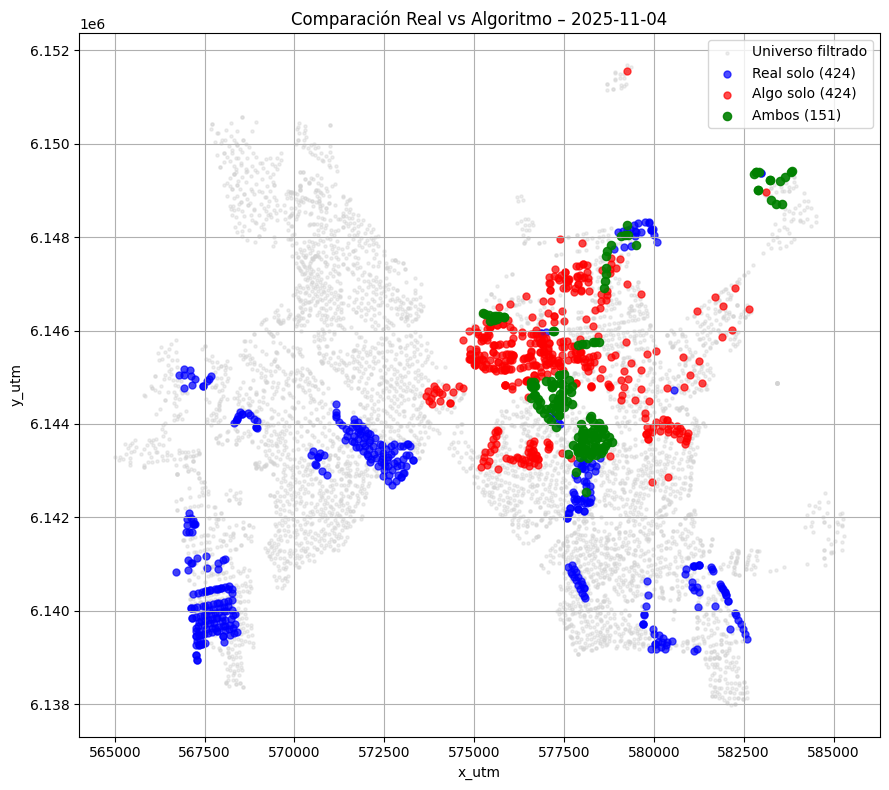


Día: 2025-11-05
Programados reales: 714
Contenedores bloqueados = 6455
CAP_EFECTIVO: 659
K sugerido: 6


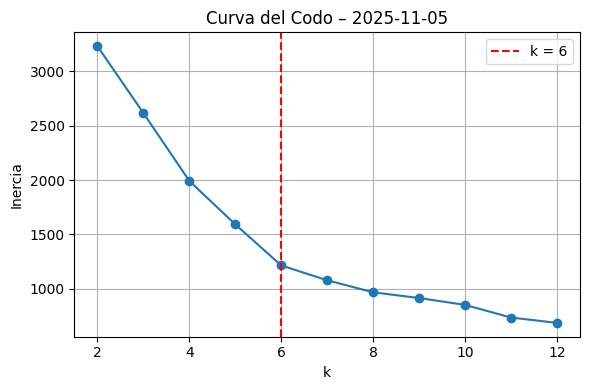


=== Resumen por clúster ===
            n  una_med  una_sum
cluster                        
5        1758     98.0   178775
2        1485     55.0   131339
4        1176     98.0   123770
0         195    515.0   113294
1        1444     55.0   111556
3           2   5775.0    11550


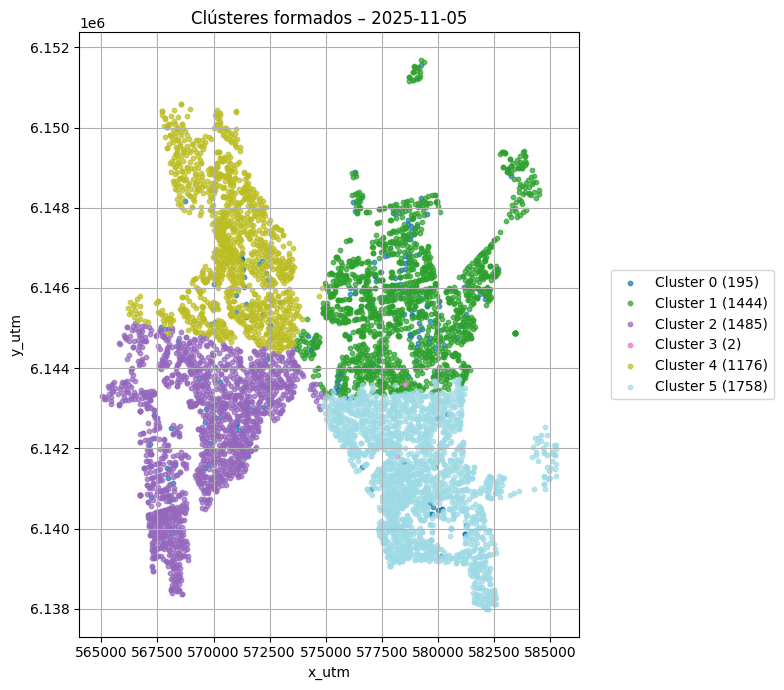


Cuotas suaves por municipio (día 2025-11-05 ):
  MUN_UNICO: 659.0

Total asignados algoritmo = 659 (objetivo CAP_TOTAL = 659)
Eficiencia real:  0.873
Eficiencia algo: 0.698


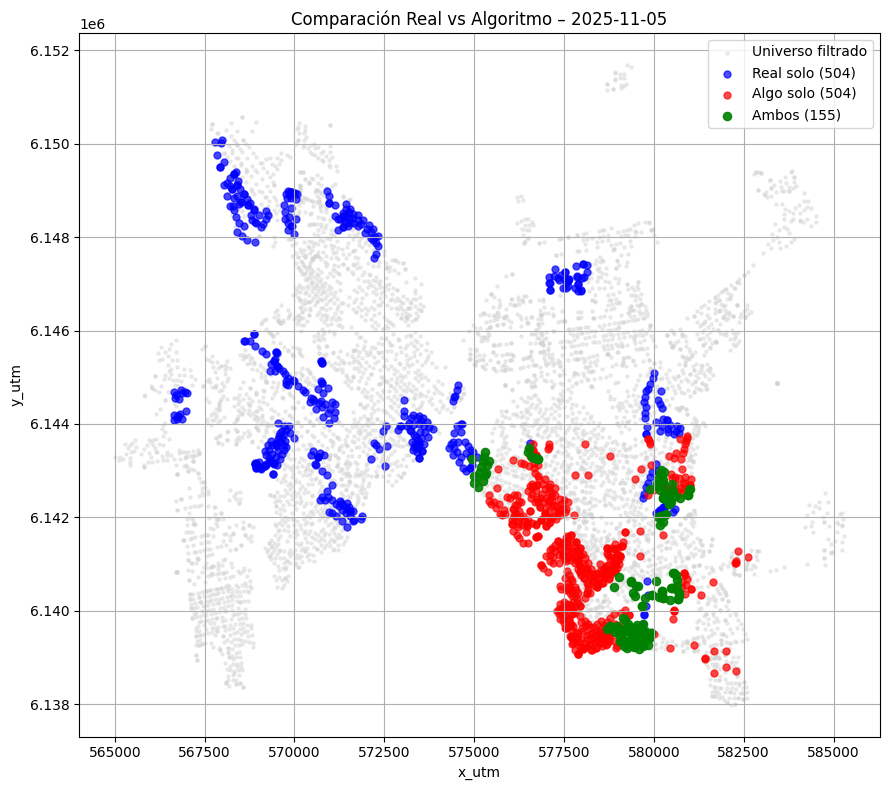


Día: 2025-11-06
Programados reales: 672
Contenedores bloqueados = 0
CAP_EFECTIVO: 630
K sugerido: 5


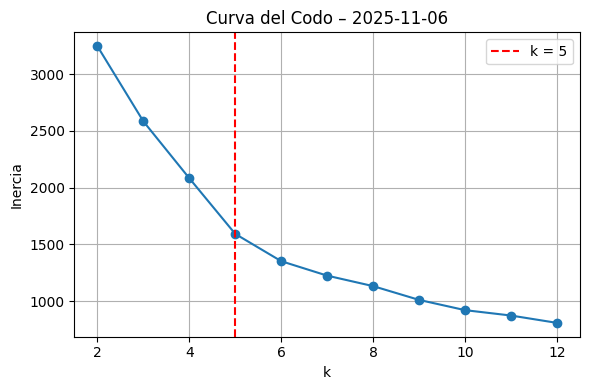


=== Resumen por clúster ===
            n  una_med  una_sum
cluster                        
0        1435    120.0   215832
1        1879    104.0   183916
3        1227    120.0   158141
2        1511     89.0   157844
4          36    991.0    39780


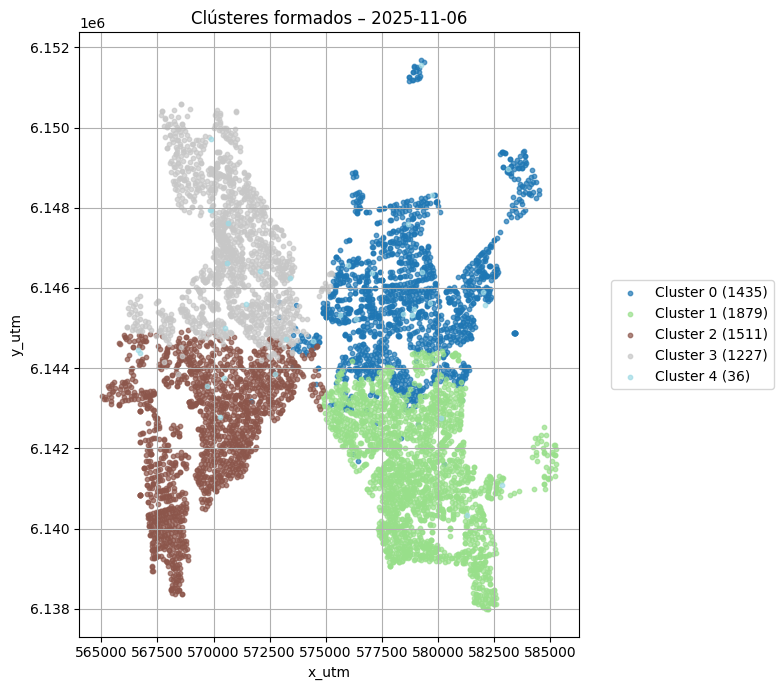


Cuotas suaves por municipio (día 2025-11-06 ):
  MUN_UNICO: 630.0

Total asignados algoritmo = 630 (objetivo CAP_TOTAL = 630)
Eficiencia real:  0.400
Eficiencia algo: 0.793


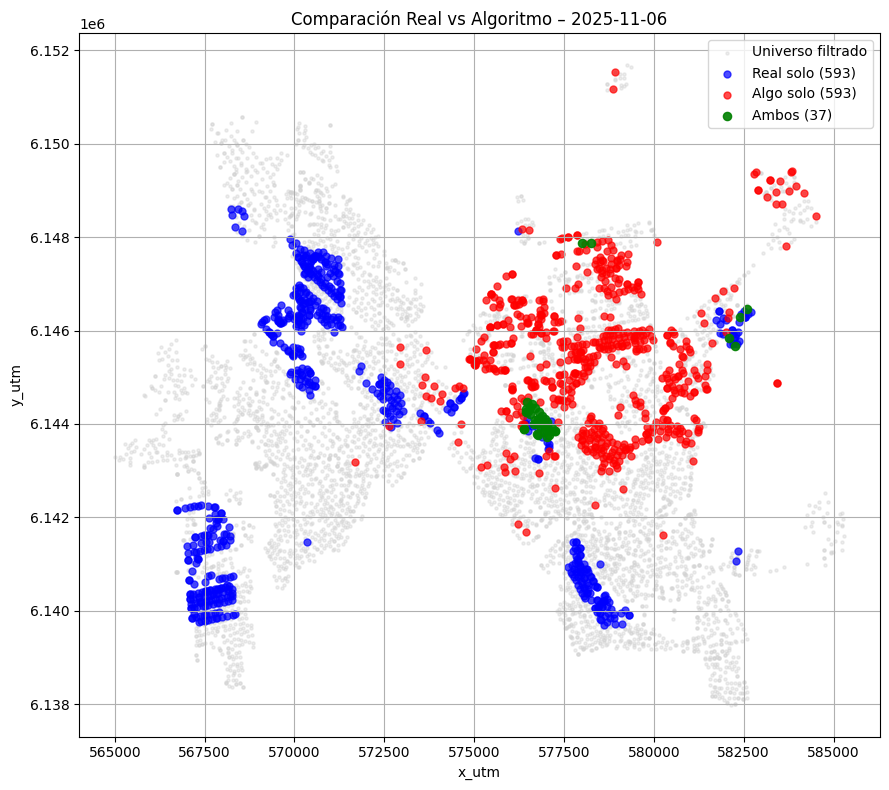


Día: 2025-11-07
Programados reales: 594
Contenedores bloqueados = 0
CAP_EFECTIVO: 565
K sugerido: 5


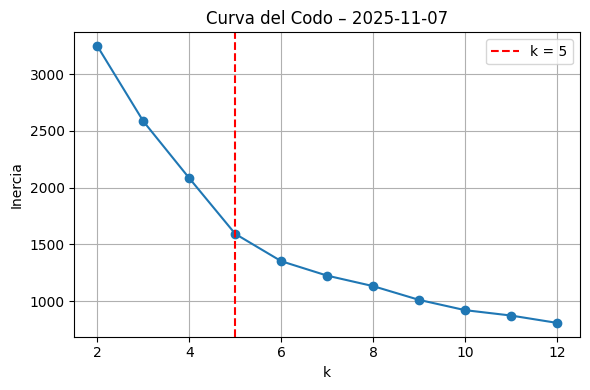


=== Resumen por clúster ===
            n  una_med  una_sum
cluster                        
0        1436    120.0   215708
1        1878    104.0   183912
3        1225    120.0   158133
2        1513     89.0   157650
4          36    991.0    39780


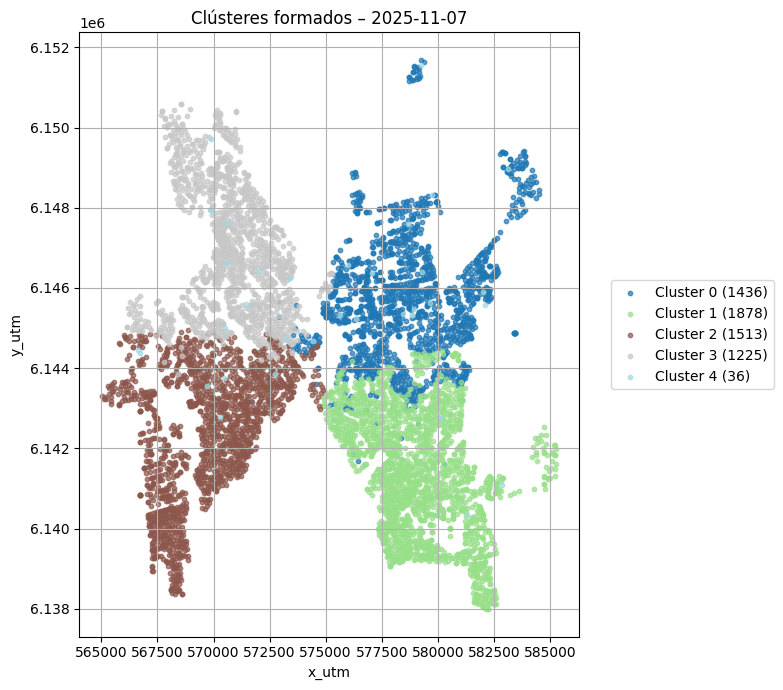


Cuotas suaves por municipio (día 2025-11-07 ):
  MUN_UNICO: 565.0

Total asignados algoritmo = 565 (objetivo CAP_TOTAL = 565)
Eficiencia real:  0.415
Eficiencia algo: 0.801


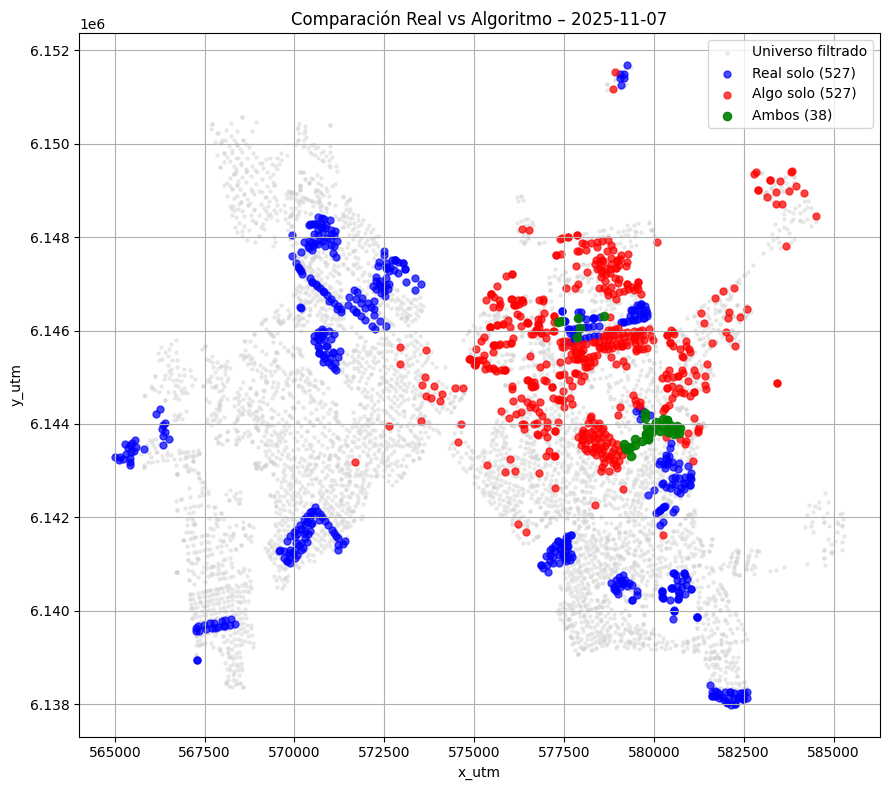


Día: 2025-11-08
Programados reales: 299
Contenedores bloqueados = 7216
CAP_EFECTIVO: 271
K sugerido: 5


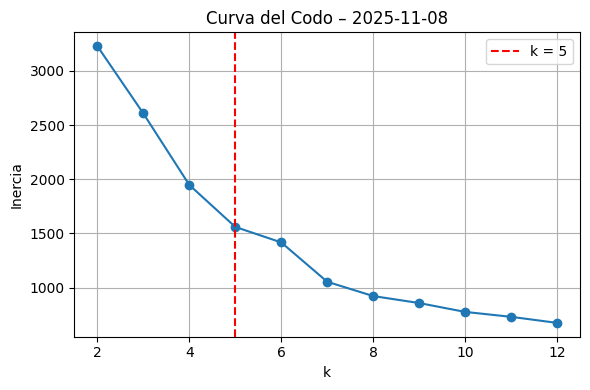


=== Resumen por clúster ===
            n  una_med  una_sum
cluster                        
1        1785     55.0   126374
2        1479     86.0   125426
4        1222     86.0   121535
0        1510     55.0   114136
3          75    665.0    65479


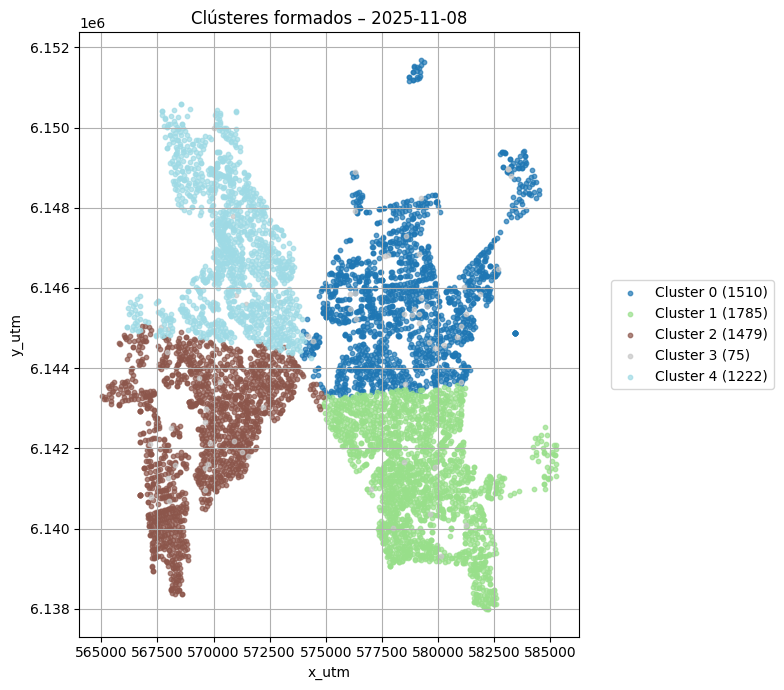


Cuotas suaves por municipio (día 2025-11-08 ):
  MUN_UNICO: 271.0

Total asignados algoritmo = 271 (objetivo CAP_TOTAL = 271)
Eficiencia real:  0.762
Eficiencia algo: 0.716


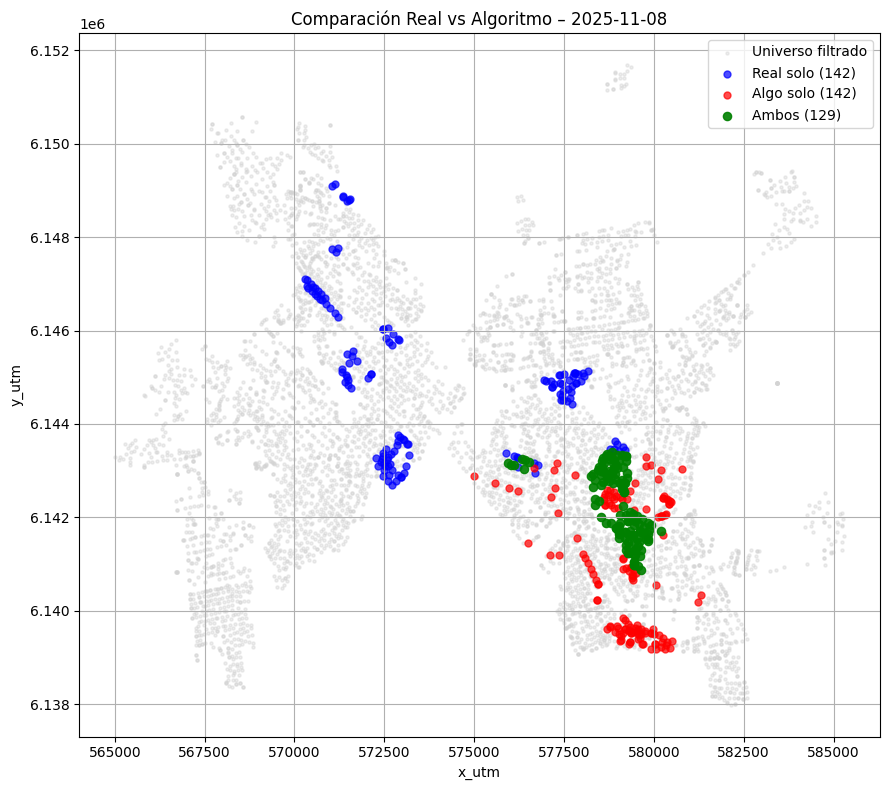


================= RESULTADOS =================
        fecha  CAP_REAL  CAP_EFECTIVO  delta_UNA_real  delta_UNA_algo  \
0  2025-11-03       794           733          -82360         -192046   
1  2025-11-04       629           575         -143262         -136208   
2  2025-11-05       714           659         -134835         -107711   
3  2025-11-06       672           630          -73105         -144977   
4  2025-11-07       594           565          -69978         -135004   
5  2025-11-08       299           271          -53169          -49962   

   delta_UNA_ideal   ef_real   ef_algo  
0          -205744  0.400303  0.933422  
1          -189212  0.757151  0.719870  
2          -154404  0.873261  0.697592  
3          -182756  0.400014  0.793282  
4          -168586  0.415088  0.800802  
5           -69737  0.762422  0.716435  

Exportado → comparacion_real_vs_algo_optimizado.csv


In [ ]:
# ======================================================================
#      O P C I O N   A   –   V E R S I Ó N   O P T I M I Z A D A
# COMPARACIÓN REAL vs ALGORITMO
# (Greedy + Territorialidad + Filtro Operativo + Cuota suave por municipio)
# ======================================================================

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import timedelta
from collections import defaultdict

# --------------------------------------------
# RUTAS
# --------------------------------------------
RUTA_DATASET_REAL = Path("/content/drive/MyDrive/Datasetviajesreales2-11_2-12.csv")
RUTA_SNAPSHOTS    = Path("/content/drive/MyDrive/snapshots_14h")
RUTA_COORDS       = Path("/content/gid_coords_utm21s.csv")

# --------------------------------------------
# PARÁMETROS
# --------------------------------------------
W_XY, W_UNA = 0.5, 0.5
K_MIN, K_MAX = 2, 12
RANDOM_STATE = 42

# Territorialidad intra–cluster
R = 250                      # radio local en metros
PORCENTAJE_SEMILLAS = 0.10   # 10% mayores UNA

# Peso de la penalización por exceder la cuota de municipio
W_PENAL_MUNI = 0.10

# --------------------------------------------
# FILTROS
# --------------------------------------------
EXCLUIR_CIRCUITOS = [
    "B_01","B_02","B_03","B_04","B_05","B_06","B_07",
    "CH_101","CH_102","CH_103","CH_104","CH_105","CH_106","CH_107",
    "CH_108","CH_109","CH_110","CH_111","CH_112","CH_113","CH_114",
    "CH_115","CH_116","CH_117","CH_118","CH_119","CH_120","CH_121",
    "CH_122","CH_123","E_111","C_101","C_102","C_103","C_104","C_105",
    "C_106","C_107","C_108","C_109","C_110","C_111","C_112","C_113",
    "C_114","C_115","C_116","B_101","B_102","B_103","E_104","E_105",
    "E_109","E_110","E_112","E_113","E_114","E_115","E_116"
]

MOTIVOS_EXCLUIR_TEXTO = [
    "No Está (20)","Roto (18)","Fuego (19)","Sobrepeso (11)",
    "Fuera de Alcance (21)","Tapa Bloqueda (14)","Fuego(19)",
    "Buzonera Girada (24)","Volcado (22)"
]

# --------------------------------------------
# HELPERS
# --------------------------------------------
def norm_cols(df):
    df = df.copy()
    df.columns = (
        df.columns
          .str.strip().str.lower()
          .str.replace("  ", " ", regex=False)
          .str.replace(" ", "_", regex=False)
    )
    return df

def pick_gid(cols):
    for c in ["gid","id","id_contenedor"]:
        if c in cols:
            return c
    return next(c for c in cols if "gid" in c)

def pick_una(cols):
    for c in cols:
        if "una" in c.lower():
            return c
    raise ValueError("No encuentro UNA")

def pick_circuito(cols):
    return next((c for c in cols if "circuit" in c.lower()), None)

def knee_point(ks, inertias):
    ks = np.array(ks)
    inertias = np.array(inertias)
    x1, y1 = ks[0], inertias[0]
    x2, y2 = ks[-1], inertias[-1]
    dx, dy = x2-x1, y2-y1
    dist = np.abs(dx*(inertias - y1) - dy*(ks-x1)) / np.hypot(dx,dy)
    return ks[np.argmax(dist)]

def cargar_snapshots_indexados():
    archivos = list(RUTA_SNAPSHOTS.glob("*.ods"))
    out = {}
    for a in archivos:
        partes = a.name.split("_")
        tag = next(p for p in partes if "-" in p and "h" not in p)
        dd, mm = tag.split("-")
        out[(int(dd), int(mm))] = a
    return out


# --------------------------------------------
# 1) CARGA REAL
# --------------------------------------------
real = pd.read_csv(RUTA_DATASET_REAL, dtype={"contenedor_gid":str,"circuito":str})
real["fecha_pasaje"] = pd.to_datetime(real["fecha_pasaje"], errors="coerce")
real = real.dropna(subset=["fecha_pasaje"])
real["dia"] = real["fecha_pasaje"].dt.date
real["turno"] = real["turno"].astype(str)

real_v = real[real["turno"].str.lower().str.contains("vespertino")].copy()
dias_reales = sorted(real_v["dia"].unique())
print("Días reales:", dias_reales)

# Snapshots + coordenadas
snapshots = cargar_snapshots_indexados()
coords = pd.read_csv(RUTA_COORDS, dtype={"gid":str})
coords["gid"] = coords["gid"].astype(str).str.strip()

# --------------------------------------------
# LOOP PRINCIPAL
# --------------------------------------------
resultados = []

for dia in dias_reales:
    print("\n=================================================")
    print("Día:", dia)
    print("=================================================")

    dd, mm = dia.day, dia.month
    if (dd, mm) not in snapshots:
        print("⚠ No hay snapshot")
        continue

    # ----------------- REAL -----------------
    real_d = real_v[real_v["dia"] == dia].copy()
    real_d = real_d[~real_d["circuito"].isin(EXCLUIR_CIRCUITOS)].copy()
    real_d = real_d.drop_duplicates(subset=["contenedor_gid"])
    CAP_REAL = len(real_d)
    print("Programados reales:", CAP_REAL)

    if CAP_REAL == 0:
        continue

    # ---------------- SNAPSHOT ----------------
    snap_raw = pd.read_excel(snapshots[(dd,mm)], engine="odf")
    snap_raw = norm_cols(snap_raw)

    gid_col  = pick_gid(snap_raw.columns)
    una_col  = pick_una(snap_raw.columns)
    circ_col = pick_circuito(snap_raw.columns)

    cols   = [gid_col, una_col]
    rename = {gid_col:"gid", una_col:"una"}
    if circ_col:
        cols.append(circ_col)
        rename[circ_col] = "circuito"

    # snapshot base
    snap = snap_raw[cols].rename(columns=rename)
    snap["gid"] = snap["gid"].astype(str).str.strip()
    snap["una"] = pd.to_numeric(snap["una"], errors="coerce").fillna(0)

    # Marcamos "bloqueado": contenedores levantados ayer o hoy antes de las 14:00
    snap["bloqueado"] = False
    if ("estado" in snap_raw.columns) and ("fecha_pasaje" in snap_raw.columns):
        snap["fecha_pasaje_dt"] = pd.to_datetime(
            snap_raw["fecha_pasaje"].astype(str).str.replace(".", ":", regex=False),
            dayfirst=True,
            errors="coerce"
        )
        snap["estado_norm"] = snap_raw["estado"].astype(str).str.lower().str.strip()

        dia_ayer = dia - timedelta(days=1)

        mask_lev         = snap["estado_norm"] == "levantado"
        mask_ayer        = snap["fecha_pasaje_dt"].dt.date == dia_ayer
        mask_hoy_maniana = (
            (snap["fecha_pasaje_dt"].dt.date == dia)
            & (snap["fecha_pasaje_dt"].dt.hour < 14)
        )

        snap.loc[(mask_lev & (mask_ayer | mask_hoy_maniana)), "bloqueado"] = True
        print(f"Contenedores bloqueados = {snap['bloqueado'].sum()}")

    # Filtrar circuitos
    if circ_col:
        snap = snap[~snap["circuito"].isin(EXCLUIR_CIRCUITOS)]

    # Merge coords
    base = snap.merge(coords, on="gid", how="left")
    base = base.dropna(subset=["x_utm","y_utm"])

    # Alinear universo real con snapshot
    real_d = real_d[real_d["contenedor_gid"].isin(set(base["gid"]))]
    CAP_EFECTIVO = len(real_d)
    print("CAP_EFECTIVO:", CAP_EFECTIVO)

    if CAP_EFECTIVO == 0:
        continue

    CAP_TOTAL = CAP_EFECTIVO

    # UNA real
    real_merge = real_d.merge(
        base[["gid","una"]],
        left_on="contenedor_gid",
        right_on="gid",
        how="inner"
    )
    suma_UNA_real = real_merge["una"].sum()
    delta_UNA_real = -suma_UNA_real

    # ---------------- CLUSTER ----------------
    X = base[["x_utm","y_utm","una"]].to_numpy(float)
    Xz = StandardScaler().fit_transform(X)
    Xz[:,0] *= W_XY
    Xz[:,1] *= W_XY
    Xz[:,2] *= W_UNA

    inertias = []
    ks = list(range(K_MIN, K_MAX+1))
    for k in ks:
        km_t = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        km_t.fit(Xz)
        inertias.append(km_t.inertia_)

    k_final = knee_point(ks, inertias)
    print("K sugerido:", k_final)

    # --- VISUAL 1: Curva del codo ---
    plt.figure(figsize=(6,4))
    plt.plot(ks, inertias, marker="o")
    plt.axvline(k_final, color="red", linestyle="--", label=f"k = {k_final}")
    plt.title(f"Curva del Codo – {dia}")
    plt.xlabel("k")
    plt.ylabel("Inercia")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    km = KMeans(n_clusters=k_final, random_state=RANDOM_STATE, n_init="auto")
    base["cluster"] = km.fit_predict(Xz)

    # RESUMEN CLUSTER
    resumen_clusters = (
        base.groupby("cluster")["una"]
        .agg(n="count", una_med="median", una_sum="sum")
        .sort_values("una_sum", ascending=False)
    )
    print("\n=== Resumen por clúster ===")
    print(resumen_clusters)

    # --- VISUAL 2: Clústeres en el plano ---
    plt.figure(figsize=(8,7))
    clusters_unicos = sorted(base["cluster"].unique())
    colores = plt.cm.tab20(np.linspace(0,1,len(clusters_unicos)))
    for col, c in zip(colores, clusters_unicos):
        subc = base[base["cluster"] == c]
        plt.scatter(subc["x_utm"], subc["y_utm"], s=10, c=[col], alpha=0.7,
                    label=f"Cluster {c} ({len(subc)})")
    plt.title(f"Clústeres formados – {dia}")
    plt.xlabel("x_utm")
    plt.ylabel("y_utm")
    plt.legend(bbox_to_anchor=(1.05,0.5), loc="center left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # PRIORIDADES
    res = resumen_clusters.reset_index()
    res["prior"] = res["una_sum"]*0.5 + res["una_med"]*0.5

    # filtro por mediana
    clusters_validos = res[res["una_med"] <= 400]["cluster"]
    base_f = base[base["cluster"].isin(clusters_validos)].copy()

    tabla_prior = (
        res[res["cluster"].isin(clusters_validos)]
        .sort_values("prior", ascending=False)[["cluster","prior"]]
    )
    tabla_prior["prioridad_cluster"] = tabla_prior.rank(
        method="dense", ascending=False
    )["prior"]

    base_f = base_f.merge(
        tabla_prior[["cluster","prioridad_cluster"]],
        on="cluster", how="left"
    )

    # ----------------------------------------
    #  CUOTA SUAVE POR MUNICIPIO
    #  (usando el campo 'circuito' tipo B_07 → municipio = 'B')
    # ----------------------------------------
    if "circuito" in base_f.columns:
        base_f["municipio"] = base_f["circuito"].str.split("_").str[0]
    else:
        # fallback: todo a un solo municipio ficticio
        base_f["municipio"] = "MUN_UNICO"

    # universo elegible para cuota (no bloqueado)
    eligibles_global = base_f[base_f["bloqueado"] == False].copy()
    total_eligibles = len(eligibles_global)

    cuotas_mun = {}
    if total_eligibles > 0:
        for muni, grp in eligibles_global.groupby("municipio"):
            cuotas_mun[muni] = CAP_TOTAL * len(grp) / total_eligibles
    else:
        # Fallback: cuota total a uno genérico
        cuotas_mun["MUN_UNICO"] = CAP_TOTAL

    print("\nCuotas suaves por municipio (día", dia, "):")
    for muni, q in cuotas_mun.items():
        print(f"  {muni}: {q:.1f}")

    # contador de asignados por municipio
    asignados_mun = defaultdict(int)

    # ======================================================
    #  GREEDY TERRITORIAL + FILTRO OPERATIVO + CUOTA MUNI
    # ======================================================

    picks = []
    total_asignados = 0

    clusters_ordenados = tabla_prior.sort_values("prioridad_cluster")["cluster"]

    for c in clusters_ordenados:
        sub = base_f[base_f["cluster"] == c].copy()

        # EXCLUIMOS BLOQUEADOS del greedy
        sub_valid = sub[sub["bloqueado"] == False].copy()
        if sub_valid.empty:
            continue

        faltan = CAP_TOTAL - total_asignados
        if faltan <= 0:
            break

        # Semillas
        n_sem = max(1, int(len(sub_valid) * PORCENTAJE_SEMILLAS))
        semillas = sub_valid.nlargest(n_sem, "una").copy()

        chosen = [semillas.nlargest(1,"una")]
        remaining = sub_valid.drop(chosen[0].index)

        rem_xy = remaining[["x_utm","y_utm"]].to_numpy()

        while len(chosen) < faltan and len(remaining) > 0:

            # centroides de los ya elegidos
            ch_xy = np.array([[ch["x_utm"].iloc[0], ch["y_utm"].iloc[0]] for ch in chosen])
            d2 = ((rem_xy[:,None,:] - ch_xy[None,:,:])**2).sum(axis=2)

            # densidad territorial
            dens = (d2 < (R*R)).sum(axis=1)

            # distancia al centro actual
            cx, cy = ch_xy[:,0].mean(), ch_xy[:,1].mean()
            dist2_cent = (remaining["x_utm"]-cx)**2 + (remaining["y_utm"]-cy)**2

            # --------- Penalización por cuota municipal ---------
            muni_rem = remaining["municipio"]
            # factor = asignados_mun / cuota_muni (si cuota_muni es 0, tomamos 1 para evitar div/0)
            factores = []
            for idx_row, m in muni_rem.items():
                cuota_m = cuotas_mun.get(m, CAP_TOTAL)
                if cuota_m <= 0:
                    cuota_m = 1.0
                factores.append(asignados_mun[m] / cuota_m)
            factores = pd.Series(factores, index=remaining.index)
            # Sólo penalizamos cuando el factor > 1 (sobre–cuota)
            penal_muni = factores.clip(lower=0)
            penal_rank = penal_muni.rank(pct=True)

            # scoring final
            score = (
                remaining["una"].rank(pct=True)*0.6
                - dist2_cent.rank(pct=True)*0.2
                - pd.Series(dens, index=remaining.index).rank(pct=True)*0.1
                - penal_rank * W_PENAL_MUNI
            )

            idx_best = score.idxmax()
            nxt = remaining.loc[[idx_best]]

            # actualizar contadores municipales
            muni_nxt = nxt["municipio"].iloc[0]
            asignados_mun[muni_nxt] += 1

            chosen.append(nxt)
            remaining = remaining.drop(idx_best)
            rem_xy = remaining[["x_utm","y_utm"]].to_numpy()

        sel = pd.concat(chosen)
        sel["asignado"] = 1
        sel["cluster"] = c
        sel = sel.sort_values("una", ascending=False).reset_index(drop=True)
        sel["orden_intra_cluster"] = sel.index+1

        picks.append(sel)
        total_asignados += len(sel)

    picks = pd.concat(picks, ignore_index=True)
    print(f"\nTotal asignados algoritmo = {total_asignados} (objetivo CAP_TOTAL = {CAP_TOTAL})")

    # ------------------ RESULTADOS ------------------
    suma_UNA_algo = picks["una"].sum()
    delta_UNA_algo = -suma_UNA_algo

    # Delta ideal (top UNA descendente sobre universe elegible y filtrado)
    eligibles_ideal = base_f[base_f["bloqueado"] == False].copy()
    ideal = eligibles_ideal.sort_values("una", ascending=False).head(CAP_TOTAL)
    delta_ideal = -ideal["una"].sum()

    eficiencia_real = abs(delta_UNA_real) / abs(delta_ideal) if delta_ideal != 0 else np.nan
    eficiencia_algo = abs(delta_UNA_algo) / abs(delta_ideal) if delta_ideal != 0 else np.nan

    print(f"Eficiencia real:  {eficiencia_real:.3f}")
    print(f"Eficiencia algo: {eficiencia_algo:.3f}")

    # ---------- VISUAL 3: COMPARACIÓN REAL vs ALGORITMO ----------
    gids_real = set(real_merge["contenedor_gid"])
    gids_algo = set(picks["gid"])

    inter     = gids_real & gids_algo
    solo_real = gids_real - gids_algo
    solo_algo = gids_algo - gids_real

    base_plot = base_f.copy()

    plt.figure(figsize=(9,8))
    # universo
    plt.scatter(base_plot["x_utm"], base_plot["y_utm"],
                s=5, c="lightgrey", alpha=0.4, label="Universo filtrado")

    # sólo real
    br = base_plot[base_plot["gid"].isin(solo_real)]
    plt.scatter(br["x_utm"], br["y_utm"], s=25, c="blue", alpha=0.7,
                label=f"Real solo ({len(solo_real)})")

    # sólo algoritmo
    ba = base_plot[base_plot["gid"].isin(solo_algo)]
    plt.scatter(ba["x_utm"], ba["y_utm"], s=25, c="red", alpha=0.7,
                label=f"Algo solo ({len(solo_algo)})")

    # intersección
    bi = base_plot[base_plot["gid"].isin(inter)]
    plt.scatter(bi["x_utm"], bi["y_utm"], s=35, c="green", alpha=0.9,
                label=f"Ambos ({len(inter)})")

    plt.title(f"Comparación Real vs Algoritmo – {dia}")
    plt.xlabel("x_utm")
    plt.ylabel("y_utm")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    resultados.append({
        "fecha": dia,
        "CAP_REAL": CAP_REAL,
        "CAP_EFECTIVO": CAP_EFECTIVO,
        "delta_UNA_real": delta_UNA_real,
        "delta_UNA_algo": delta_UNA_algo,
        "delta_UNA_ideal": delta_ideal,
        "ef_real": eficiencia_real,
        "ef_algo": eficiencia_algo
    })


# --------------------------------------------
# RESULTADOS FINALES
# --------------------------------------------
df_res = pd.DataFrame(resultados)
print("\n================= RESULTADOS =================")
print(df_res)

df_res.to_csv("/content/comparacion_real_vs_algo_optimizado.csv",
              index=False, encoding="utf-8-sig")
print("\nExportado → comparacion_real_vs_algo_optimizado.csv")